In [717]:
import pandas as pd
import numpy as np

import re

from sklearn.preprocessing import StandardScaler
import math
import scipy.stats as st
from scipy.stats import bayes_mvs
from scipy.sparse import csr_matrix

from time import time
import copy
import pickle
import missingno as msno

import itertools
from collections import Counter
from collections import deque 

In [718]:
!ls

bayes_avg_eqn.png   ingr_map.pkl		 PP_users.csv
cleaned_data.pkl    interactions_test.csv	 RAW_interactions.csv
concat_df.pkl	    interactions_train.csv	 RAW_recipes.csv
food_cluster.ipynb  interactions_validation.csv  README.md
food_EDA.ipynb	    PP_recipes.csv		 view_pkl.ipynb


<h4><b>What is the Bayesian average?</b></h4>
The Bayesian average uses two constants to offset the arithmetic average of an individual product. This is important as otherwise products with only one five star rating are affoarding the same quality ranking as products with thousands of five star reviews. To account for differences in certainty, the rating for recipes with less than a critical number of reviews are adjusted, whlile recipes above this threshold are only very slightly adjusted. The critical value (C) is the number of reviews of the 25% quartile, which for our dataset is 1. The formula for the Bayesian average (r bar) is shown below where r and c are the rating and rating count for an individual recipe and C and R are critical threshold and average rating.

<h3></h3>
<h3>Importing data</h3>

In [719]:
def import_data():
    #cleaned recipes
    recipes = pd.read_csv('PP_recipes.csv')
    del recipes['i']
    del recipes['name_tokens']
    del recipes['ingredient_tokens']
    del recipes['steps_tokens']
    recipes = recipes.set_index('id')

    #ratings
    ratings = pd.read_csv('RAW_interactions.csv')
    del ratings['user_id']
    del ratings['date']
    del ratings['review']
    ratings = ratings.set_index('recipe_id')

    #raw recipe info
    raw_recipes = pd.read_csv('RAW_recipes.csv')
    del raw_recipes['contributor_id']
    del raw_recipes['submitted']
    del raw_recipes['tags']
    del raw_recipes['steps']
    del raw_recipes['description']
    raw_recipes = raw_recipes.set_index('id')

    return (recipes, raw_recipes, ratings)

In [720]:
recipes_, raw_recipes_, ratings_ = import_data()

In [721]:
ratings

,rating
recipe_id,
40893,4
40893,5
44394,4
85009,5
85009,5
...,...
72730,0
386618,5
78003,5


<Axes: >

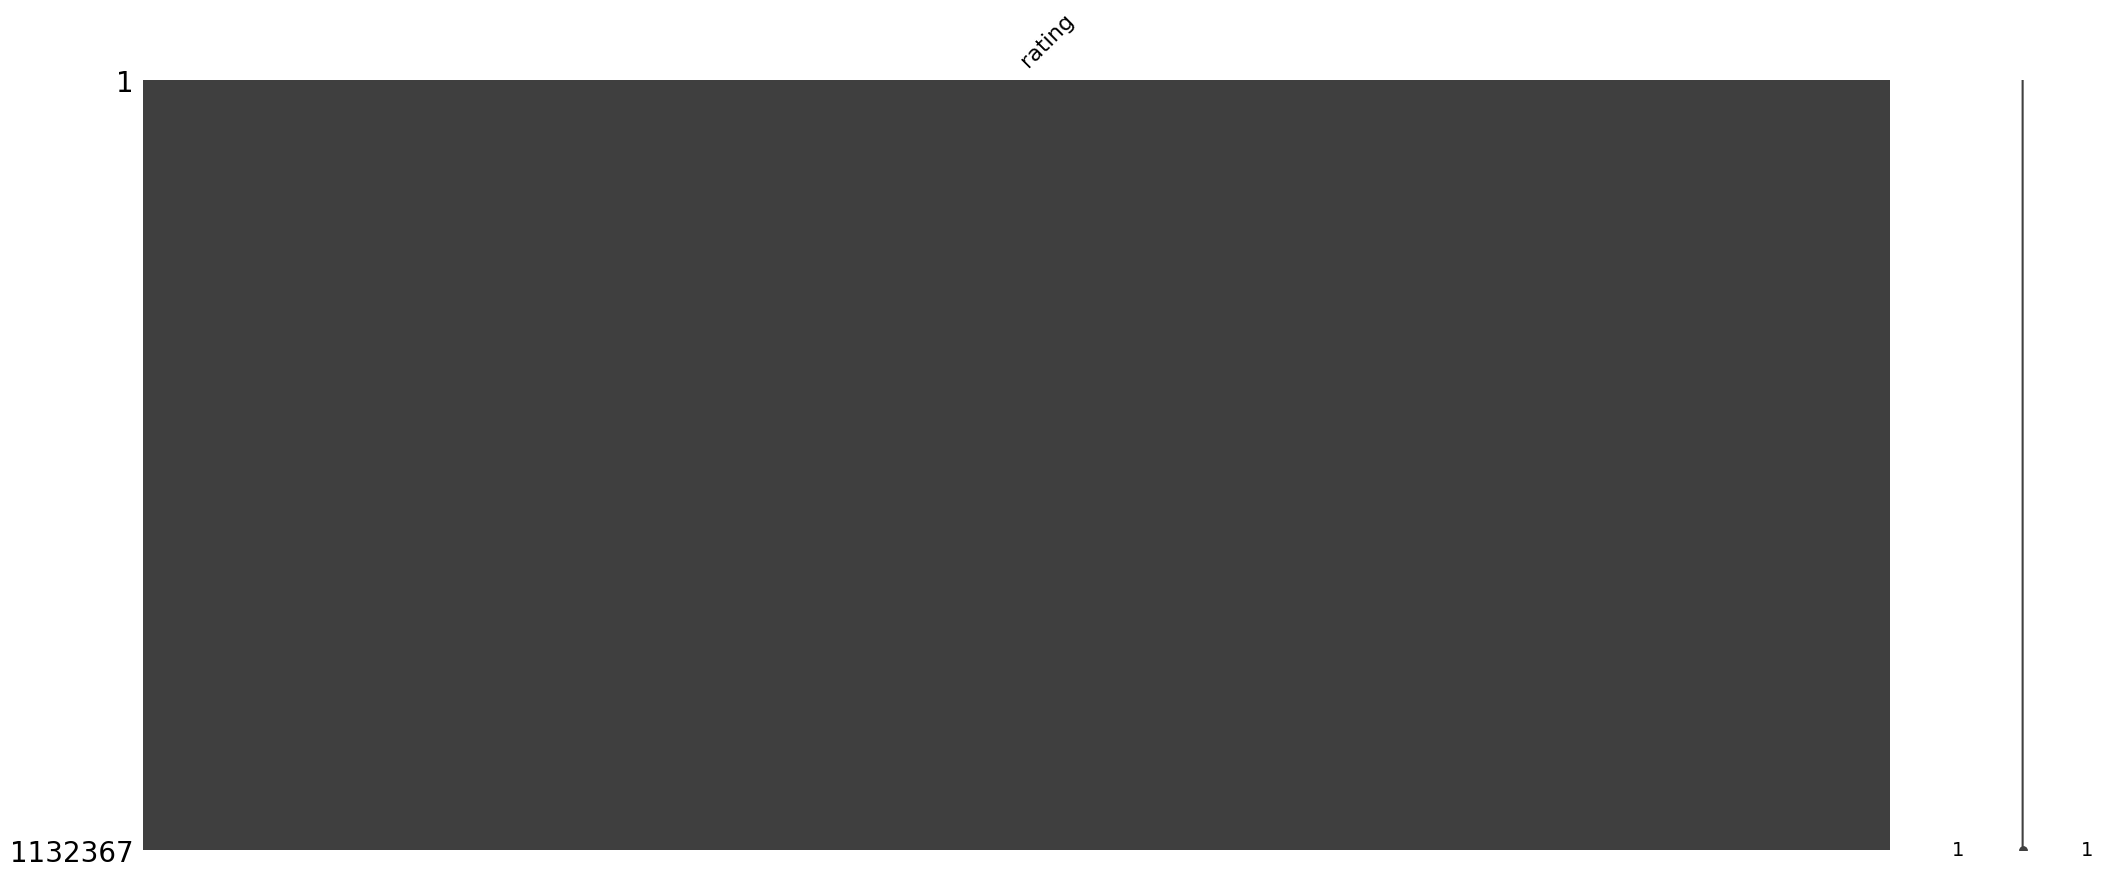

In [722]:
msno.matrix(ratings)

In [723]:
raw_recipes

,name,minutes,nutrition,n_steps,ingredients,n_ingredients
id,,,,,,
137739,arriba baked winter squash mexican style,55,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['winter squash', 'mexican seasoning', 'mixed ...",7
31490,a bit different breakfast pizza,30,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['prepared pizza crust', 'sausage patty', 'egg...",6
112140,all in the kitchen chili,130,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['ground beef', 'yellow onions', 'diced tomato...",13
59389,alouette potatoes,45,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,"['spreadable cheese with garlic and herbs', 'n...",11
44061,amish tomato ketchup for canning,190,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,"['tomato juice', 'apple cider vinegar', 'sugar...",8
...,...,...,...,...,...,...
486161,zydeco soup,60,"[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['celery', 'onion', 'green sweet pepper', 'gar...",22
493372,zydeco spice mix,5,"[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,"['paprika', 'salt', 'garlic powder', 'onion po...",13
308080,zydeco ya ya deviled eggs,40,"[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['hard-cooked eggs', 'mayonnaise', 'dijon must...",8


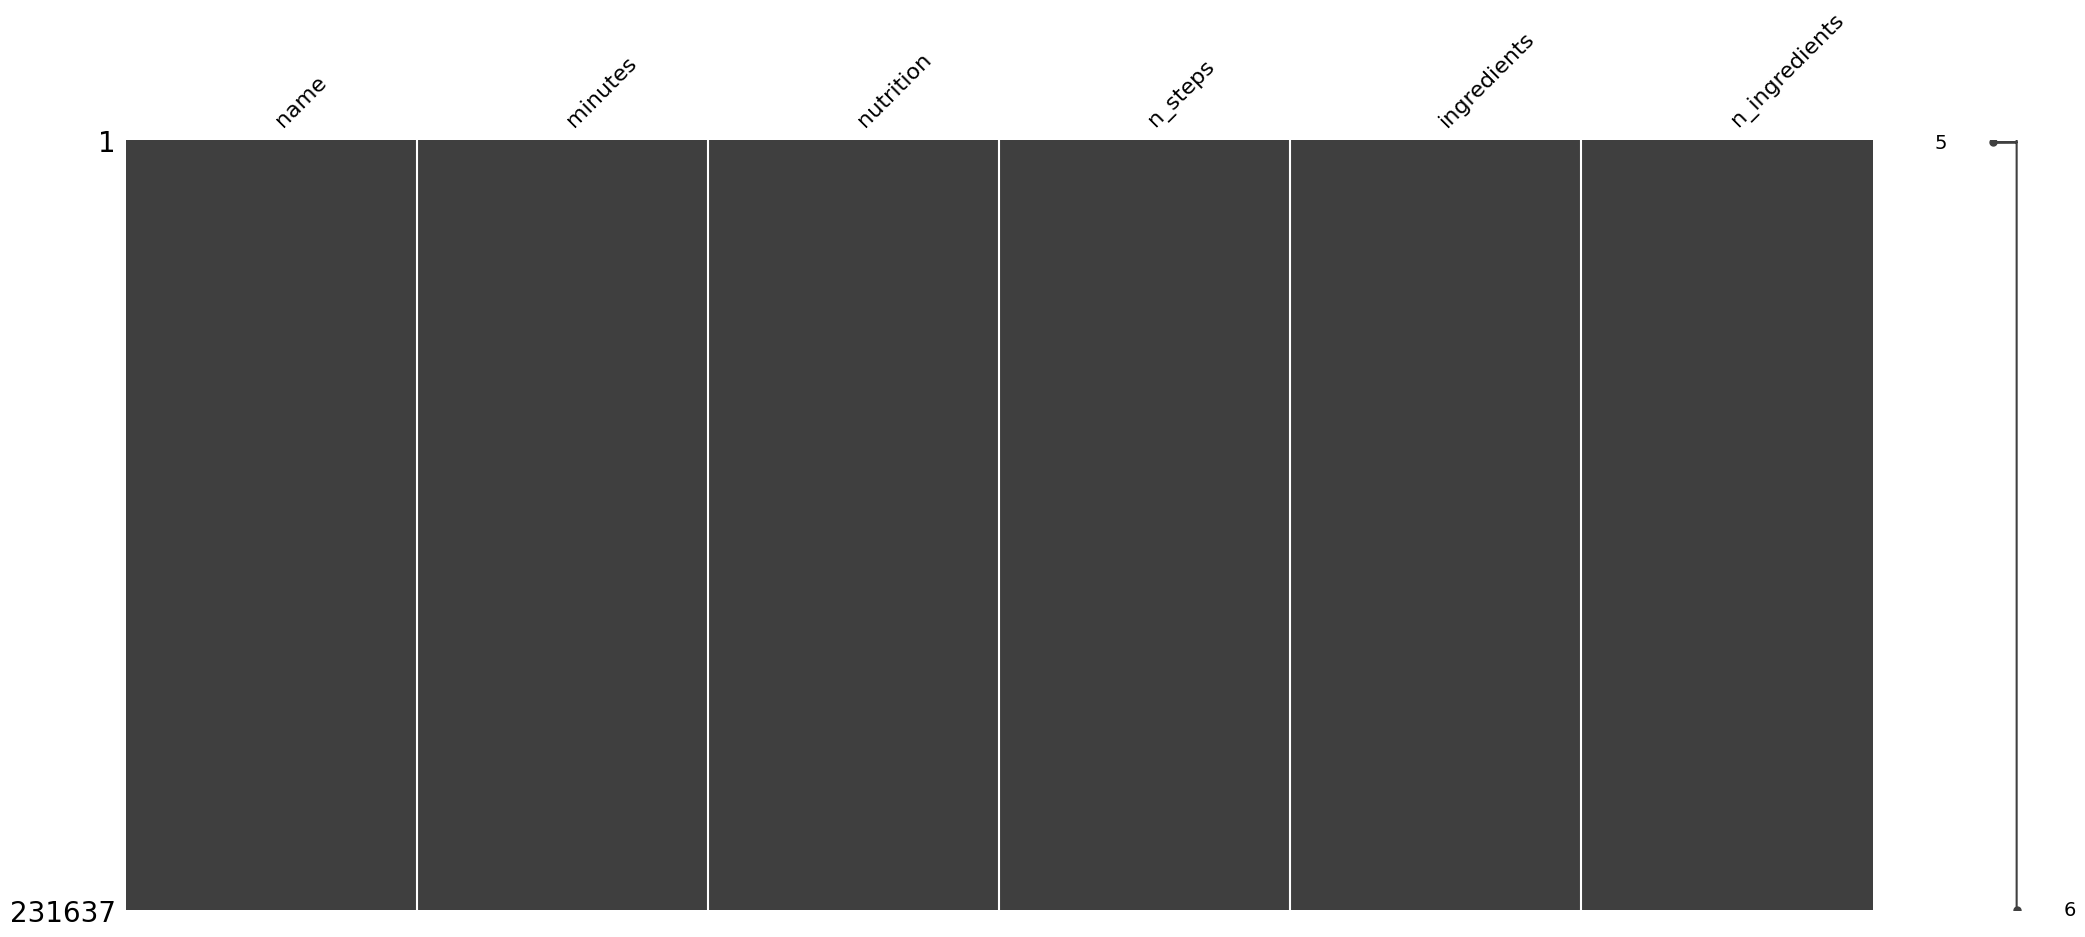

In [724]:
msno.matrix(raw_recipes);

In [725]:
recipes

,techniques,calorie_level,ingredient_ids
id,,,
424415,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527]"
146223,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 7022, 1511,..."
312329,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."
74301,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]"
76272,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[3484, 6324, 7594]"
...,...,...,...
133758,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[4231, 1257, 1833, 840, 1306, 2883, 6270, 221,..."
101199,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[3399, 4189, 5010, 4740, 3940, 6276, 6819, 723..."
188686,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[4574, 1910, 63, 6906, 2499, 332, 7449]"


<Axes: >

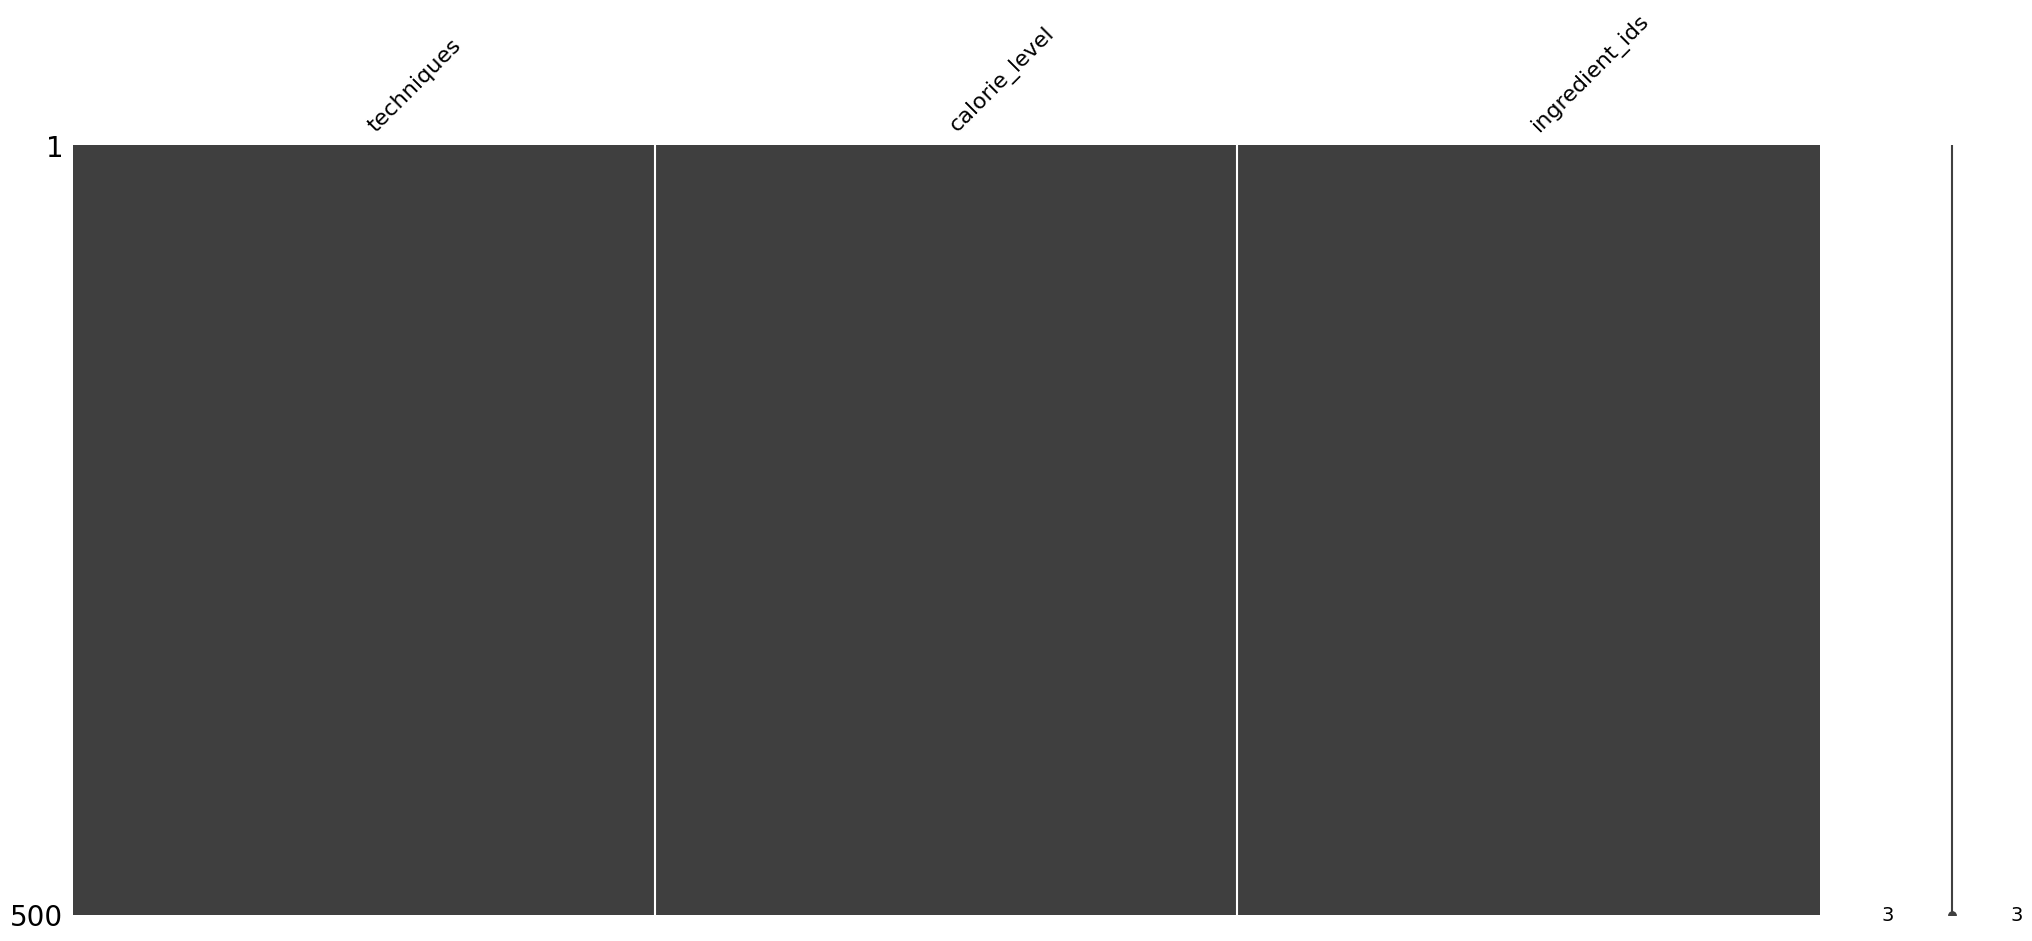

In [726]:
msno.matrix(recipes)

<h3>Ratings</h3>

In [727]:
#checking for outliers
print(f'Count of ratings > 5: {(ratings > 5).sum()[0]}')
print(f'Count of ratings < 0: {(ratings < 0).sum()[0]}')

Count of ratings > 5: 0
Count of ratings < 0: 0


In [728]:
#two methods for re-scaling reviews based on review number 

#bayesian ci
def bayes_ci(n,rating,alpha=0.95):
    mean,_,_ = bayes_mvs(n,alpha)
    return mean.statistic

#bayesian average
avg = ratings.mean()
count = ratings.count()
C = (ratings.reset_index().groupby('recipe_id').agg('size').sort_values().quantile(.25))
m = ratings.mean().rating

def bayes_avg(n):
    avg = n.mean()
    count = n.count()
    return (avg*count+C*m)/(count+C)

In [729]:
ratings_ = copy.copy(ratings)

In [730]:
q = ratings.quantile(0.95)
C = ratings.mean()

def weighted_rating(s, m=q, c=C):
    R = s.mean()
    v = s.count()
    return ((v/(v+m) * R) + (m/(m+v) * C))[0]

In [731]:
#scale ratings
def scale_ratings(ratings):
    ratings = ratings.reset_index()
    ratings = ratings.groupby('recipe_id').agg({'rating':bayes_avg})
    #ratings = ratings.reset_index()
    #df = df.drop_duplicates(subset='recipe_id')
    return ratings #df.set_index('recipe_id')

<h3>Creating reference dataset</h3>

In [732]:
df_ref = raw_recipes[['name','ingredients']]
df_ref

,name,ingredients
id,,
137739,arriba baked winter squash mexican style,"['winter squash', 'mexican seasoning', 'mixed ..."
31490,a bit different breakfast pizza,"['prepared pizza crust', 'sausage patty', 'egg..."
112140,all in the kitchen chili,"['ground beef', 'yellow onions', 'diced tomato..."
59389,alouette potatoes,"['spreadable cheese with garlic and herbs', 'n..."
44061,amish tomato ketchup for canning,"['tomato juice', 'apple cider vinegar', 'sugar..."
...,...,...
486161,zydeco soup,"['celery', 'onion', 'green sweet pepper', 'gar..."
493372,zydeco spice mix,"['paprika', 'salt', 'garlic powder', 'onion po..."
308080,zydeco ya ya deviled eggs,"['hard-cooked eggs', 'mayonnaise', 'dijon must..."


<h4>Encoding and normalizing features</h4>

In [733]:
def scale_column(df,key):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(np.array(df[key]).reshape(-1,1)),columns=[key])

In [734]:
cols_to_normalize = ['calorie_level','minutes','n_steps','n_ingredients','rating']

def normalize_select_cols(df,cols_to_normalize):
    for col in cols_to_normalize:
        df[col] = scale_column(df,col).values
    return df

<h3>Creating clustering dataset</h3>

In [735]:
#function to time fits
def timer_func(func):
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        print(f'Function {func.__name__!r} executed in {(t2-t1):.4f}s')
        return result
    return wrap_func

In [736]:
#merging data into single usable df
def merge_frames(recipes,raw_recipes, ratings):
    return recipes.merge(raw_recipes[['minutes','nutrition','n_steps','n_ingredients']],how='inner',left_index=True,right_index=True).merge(ratings,how='inner',left_index=True,right_index=True)

In [737]:
#convert string that looks lke a list of numbers to a list of 
def string_to_list(s):
    l = re.findall(r'\d+',s)
    l = [int(num) for num in l]
    return l

In [738]:
#get list of top ingredients 
def get_top(recipes=recipes,n_ingred=1000,show=False):
    if isinstance(recipes['ingredient_ids'].iloc[0],str):
        ingred = recipes['ingredient_ids'].apply(string_to_list)
    else: ingred = recipes['ingredient_ids']
    ingred = list(itertools.chain.from_iterable(ingred))
    total_num_ingred = len(Counter(ingred))
    if show:
        print(f'Total ingredient number: {total_num_ingred}')
    ingred_counts = Counter(ingred).most_common(n_ingred)
    top_ingredients = [ingred_counts[n][0] for n in range(len(ingred_counts))]
    return total_num_ingred, top_ingredients

In [739]:
total_num_ingred,_ = get_top(recipes_,show=True)
top_ingredients

Total ingredient number: 7993


[6270,
 840,
 5010,
 2499,
 6906,
 5006,
 3203,
 7655,
 4717,
 2683,
 5319,
 800,
 3184,
 332,
 6335,
 6276,
 63,
 1168,
 5180,
 335,
 4253,
 7449,
 7557,
 1093,
 6654,
 590,
 1511,
 7213,
 6696,
 1910,
 3217,
 1257,
 4623,
 4987,
 1252,
 1124,
 3723,
 7470,
 5648,
 7946,
 5168,
 2856,
 1833,
 5185,
 298,
 5966,
 7367,
 1329,
 2816,
 3497,
 4836,
 4964,
 3484,
 1119,
 7642,
 3502,
 5298,
 2148,
 4574,
 3440,
 4308,
 3355,
 5915,
 1388,
 7258,
 6324,
 2832,
 393,
 5695,
 4863,
 2131,
 342,
 2320,
 8021,
 7233,
 4096,
 2509,
 5825,
 5058,
 3668,
 2200,
 1043,
 2809,
 5106,
 2777,
 1297,
 869,
 4053,
 2007,
 6426,
 1786,
 3399,
 7229,
 150,
 339,
 4231,
 3486,
 2757,
 4384,
 3512,
 3248,
 7956,
 1505,
 2378,
 7620,
 2212,
 6009,
 5024,
 4189,
 7790,
 2817,
 2001,
 5502,
 2022,
 7887,
 2512,
 912,
 6413,
 2430,
 4880,
 1170,
 728,
 7705,
 2461,
 1986,
 7168,
 6265,
 6272,
 255,
 6473,
 5974,
 7801,
 6352,
 3219,
 4320,
 3527,
 2591,
 1254,
 382,
 1689,
 7774,
 673,
 7979,
 4958,
 1920,
 52

In [740]:
ingred = recipes_['ingredient_ids'].apply(string_to_list)
ingred = Counter(list(itertools.chain.from_iterable(ingred))).most_common()
ingred[-6000:]

[(4411, 47),
 (1215, 47),
 (4464, 46),
 (2642, 46),
 (1151, 46),
 (2967, 46),
 (6610, 46),
 (2702, 46),
 (3878, 46),
 (5359, 46),
 (4764, 46),
 (3345, 46),
 (6636, 46),
 (3886, 46),
 (7478, 46),
 (4301, 46),
 (548, 46),
 (5998, 46),
 (6917, 46),
 (1418, 46),
 (6963, 45),
 (2198, 45),
 (3552, 45),
 (6027, 45),
 (958, 45),
 (1411, 45),
 (2536, 45),
 (2355, 45),
 (51, 45),
 (3787, 45),
 (5074, 45),
 (7933, 45),
 (675, 45),
 (709, 45),
 (1436, 45),
 (5225, 45),
 (873, 44),
 (3366, 44),
 (1120, 44),
 (2610, 44),
 (7503, 44),
 (6544, 44),
 (6635, 44),
 (7600, 44),
 (3161, 44),
 (7683, 44),
 (4340, 44),
 (3521, 44),
 (7134, 44),
 (5073, 44),
 (1269, 44),
 (4437, 44),
 (3680, 44),
 (5678, 44),
 (1449, 44),
 (2271, 44),
 (275, 44),
 (3956, 44),
 (7978, 44),
 (5105, 43),
 (2595, 43),
 (1956, 43),
 (5241, 43),
 (2666, 43),
 (4935, 43),
 (5656, 43),
 (1802, 43),
 (927, 43),
 (5071, 43),
 (7110, 43),
 (271, 43),
 (2343, 43),
 (4374, 43),
 (6393, 43),
 (1003, 43),
 (6896, 43),
 (1626, 43),
 (2223, 4

In [741]:
#filtering ingredients that aren't in the top ingredient list
def trim_ingredients(recipes,size=None,top_ingredients=top_ingredients):
    if not size:
        size = recipes['ingredient_ids'].shape[0]
        #print(size)

    ingredient_list = deque([])

    for n in range(size): #df[1].shape[0]):
        test=string_to_list(recipes['ingredient_ids'].iloc[n])
        selected = [i for i in test if i in top_ingredients]
        ingredient_list.append(selected)
    recipes = recipes.iloc[:size,:]
    recipes['ingredient_ids']=ingredient_list
    return recipes

In [742]:
#convert one list column to encoded columns
def transform_to_sparse(df,key,size,encoded=False,sparse=True):
    if isinstance(df[key].iloc[0],str):
        data = df[key].apply(string_to_list)
    else: data = df[key]
    t_names = [str(n)+' '+key for n in range(size)]
    data = pd.DataFrame(data.to_list(), columns=t_names,index=df.index.values)
    if encoded:
        return data 
    else: 
        data = pd.get_dummies(data.stack(),sparse=sparse)
        data = data.groupby(level=0).sum()
        #data = data.fillna(0)
    return data

In [743]:
#convert all keys to encoded columns
def transform_all_to_sparse(df,keys,sizes,encoded=False,sparse=True):
    #encode
    for n,key in enumerate(keys):
        data = transform_to_sparse(df,key,sizes[n],encoded[n],sparse[n])
        yield data 
        #delete original columns
        try:
            df.pop(key)
        except:
            pass

In [744]:
#combine all encoded columns into one matricies with other data
def concat_df(g,df):
    df_concat = pd.concat(g,axis=1)
    df = pd.concat([df_concat,df],axis=1)
    
    return df

<h3>Data cleaning pipeline</h3>

In [745]:
#class to do all 
@timer_func
class CleanAndTransform():
    def __init__(self,n_ingred=1000,test_size=None):
        #data attributes
        self.keys  = ['techniques','ingredient_ids','nutrition']
        self.sizes = (58,20,14)
        self.encoded = (True,False,False)
        self.sparse = (False, False, False)
        self.cols_to_normalize = ['calorie_level','minutes','n_steps','n_ingredients','rating']
        
        #contorl output dimensions
        self.n_ingred = n_ingred
        self.test_size = test_size
        
        #clean data
        self.recipes, self.raw_recipes, self.ratings = import_data()   
        _,self.top_ingredients = get_top(recipes=self.recipes,n_ingred=n_ingred,show=False)
        self.recipes = trim_ingredients(recipes=self.recipes,size=self.test_size,top_ingredients=self.top_ingredients)
        self.ratings = scale_ratings(self.ratings)
        self.df = merge_frames(self.recipes, self.raw_recipes, self.ratings)
        self.df = normalize_select_cols(self.df,self.cols_to_normalize)
        self.df = self.df.fillna(0)


    def __call__(self):
        #encode data
        self.df = self.df[:self.test_size]
        self.g = transform_all_to_sparse(self.df,self.keys,self.sizes,self.encoded,self.sparse)
        df = concat_df(self.g,self.df)
        return df

In [746]:
transform = CleanAndTransform(n_ingred=2000)
df = transform()

Function 'CleanAndTransform' executed in 68.2063s


: 

: 

In [ ]:
recipes_.shape/10*5/60/24

In [ ]:
with open('cleaned_data.pkl','wb') as f:
    pickle.dump(df,f)

In [ ]:
cleaned.shape

In [ ]:
df.info()

In [ ]:
@timer_func
def to_sparse(df):
    return csr_matrix(df.values)

to_sparse(df_full)

In [ ]:
df_full.info()

<h2> Dimensionality Reduction </h2>

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
df

In [ ]:
pca = PCA(n_components = 0.95,random_state=10)
df.columns = df.columns.astype(str)
X_pca = pca.fit_transform(df)
print('PCA reduced dimensions from ', df.shape[1],' to ',X_pca.shape[1] ,' and preserved 95% of variance.')

In [ ]:
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_,color='mediumseagreen')
plt.xlabel('Principle component')
plt.ylabel('Explained variance ratio')
plt.xticks(range(pca.n_components_));